# Model selection with Scikit-Learn

## Training error

In [1]:
# Global imports and settings
from preamble import * # Ignore, this is just to make code cleaner
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''') # For slides
InteractiveShell.ast_node_interactivity = "all"

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.datasets import make_blobs

# Blob data
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10)) # Relabels numeric values to b,r

clf = KNeighborsClassifier()
clf.fit(X, y)
print("Training error =", zero_one_loss(y, clf.predict(X)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Training error = 0.108


## Test error

Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide data into two disjoint parts called training and test sets (usually using 70% for training and 30% for test).

- Use the training set for fitting the model;
- Use the test set for evaluation only, thereby yielding an unbiased estimate.
- __The same data should not be used both for training and evaluation.__

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Training error = 0.0973333333333
Test error = 0.172


## Cross-validation

Issue: 

- When data is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set. 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error. 

Solution: K-Fold cross-validation.

- Split data into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.

In [24]:
from sklearn.cross_validation import KFold

scores = []

for train, test in KFold(n=len(X), n_folds=5, random_state=42):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = KNeighborsClassifier().fit(X_train, y_train)
    scores.append(zero_one_loss(y_test, clf.predict(X_test)))

print("CV error = %f +-%f" % (np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


In [25]:
# Shortcut
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(KNeighborsClassifier(), X, y, 
                         cv=KFold(n=len(X), n_folds=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


## Metrics

### Default score

Estimators come with a built-in default evaluation score

* Accuracy for classification 
* R2 score for regression

In [26]:
y_train = (y_train == "r")
y_test = (y_test == "r")
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train) 
print("Default score =", clf.score(X_test, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Default score = 0.84


### Accuracy

Definition: The accuracy is the proportion of correct predictions.

In [27]:
from sklearn.metrics import accuracy_score
print("Accuracy =", accuracy_score(y_test, clf.predict(X_test)))

Accuracy = 0.84


### Precision, recall and F-measure

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F =", fbeta_score(y_test, clf.predict(X_test), beta=1))

Precision = 0.811881188119
Recall = 0.863157894737
F = 0.836734693878


### ROC AUC

Definition: Area under the curve of the false positive rate (FPR) against the true positive rate (TPR) as the decision threshold of the classifier is varied.

ROC AUC = 0.92977443609


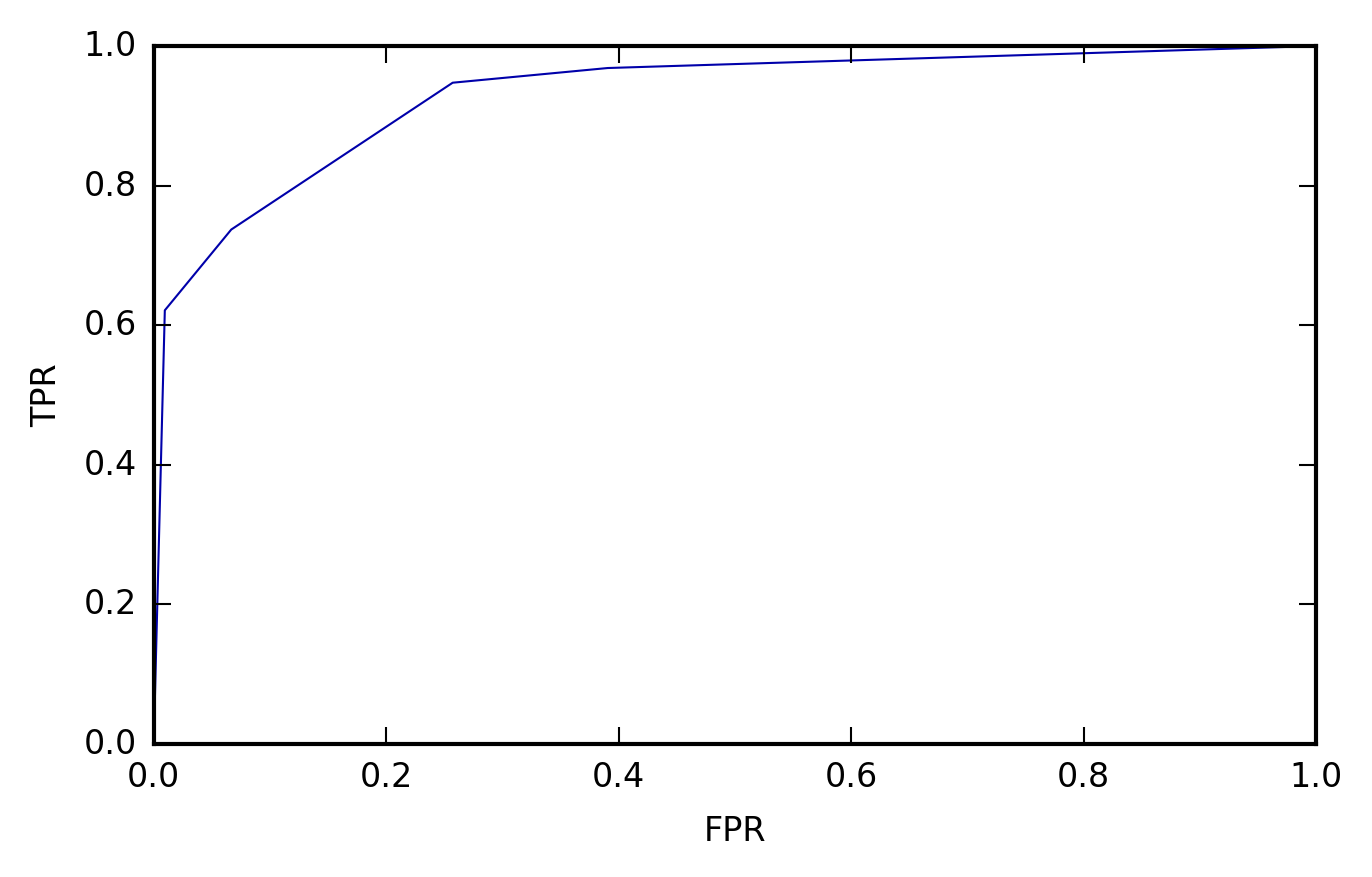

In [29]:
from sklearn.metrics import get_scorer
roc_auc_scorer = get_scorer("roc_auc")
print("ROC AUC =", roc_auc_scorer(clf, X_test, y_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Confusion matrix

Definition: number of samples of class $i$ predicted as class $j$.

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[86, 19],
       [13, 82]])

# Transformers, pipelines and feature unions

## Transformers

- Classification (or regression) is often only one or the last step of a long and complicated process;
- In most cases, input data needs to be cleaned, massaged or extended before being fed to a learning algorithm;
- For this purpose, Scikit-Learn provides the ``transformer`` API.

In [31]:
class Transformer(object):    
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
    
    def transform(self, X):
        """Transform X into Xt."""
        # transform X in some way to produce Xt
        return Xt
    
    # Shortcut
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        Xt = self.transform(X)
        return Xt

## Pipelines

Transformers can be chained in sequence to form a pipeline.

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

# Get more complex data
dataset = oml.datasets.get_dataset(337)
X, y = dataset.get_data(target=dataset.default_target_attribute)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Chain transformers + a classifier to build a new classifier
clf = make_pipeline(SelectKBest(score_func=f_classif, k=44), 
                    RandomForestClassifier())
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test)[:5])

Pipeline(steps=[('selectkbest', SelectKBest(k=44, score_func=<function f_classif at 0x1102757b8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

[[ 0.4  0.6]
 [ 0.4  0.6]
 [ 0.1  0.9]
 [ 0.9  0.1]
 [ 0.7  0.3]]


## Optimizing parameters
Search for the best hyperparameter settings

In [33]:
# Hyper-parameters can be accessed using step names
print("K =", clf.get_params()["selectkbest__k"])

K = 44


In [34]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(clf, 
                    param_grid={"selectkbest__k": [1, 10, 20, 30, 40],
                                "randomforestclassifier__max_features": [0.1, 0.25, 0.5]})
grid.fit(X_train, y_train)

print("Best params =", grid.best_params_)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=44, score_func=<function f_classif at 0x1102757b8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selectkbest__k': [1, 10, 20, 30, 40], 'randomforestclassifier__max_features': [0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Best params = {'selectkbest__k': 40, 'randomforestclassifier__max_features': 0.25}


## Final remarks

* Scikit-learn has many more preprocessing techniques. Check the documentation
* There are better ways to optimize hyperparameters:
    * RandomSearch
    * Bayesian Optimization (see auto-sklearn library)